<a href="https://colab.research.google.com/github/elisaklunder/ML-projects/blob/main/Autoencoder_on_digits_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder on handwriten digits
### Elisa Klunder, Mihkel Mariusz Jezierski, Aksel Joonas Reedi

## Import data

In [ ]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE, MDS

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms

# Seed
torch.manual_seed(42)

# check if we can use GPU
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Device: cpu


In [ ]:
# Load Digits dataset
X, y = datasets.load_digits(return_X_y=True)
digits = datasets.load_digits()
X.shape

(1797, 64)

<Figure size 640x480 with 0 Axes>

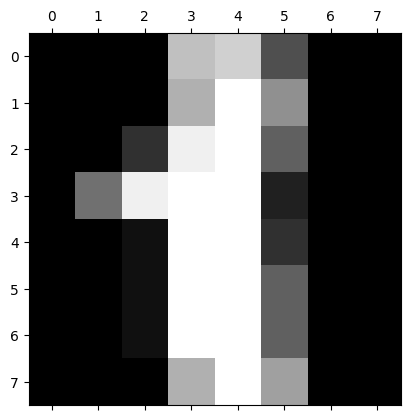

In [ ]:
# Show an example of the data
plt.gray()
plt.matshow(digits.images[1])
plt.show()

In [ ]:
# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

In [ ]:
# Split train data into train and validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.33, stratify=y_train, random_state=42
)

scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

## Autoencoder

In [ ]:
# Turning the data into tensors for pyTorch
X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val)
X_test = torch.FloatTensor(X_test)

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=X_train,
                                          batch_size=X_train.shape[0],
                                          shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=X_val,
                                          batch_size=X_val.shape[0],
                                          shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=X_test,
                                          batch_size=X_test.shape[0],
                                          shuffle=False)

In [ ]:
# Encoder
class Encoder(nn.Module):
  def __init__(self, act_fn : object = nn.GELU):
    super().__init__()
    c_hid = 8
    self.encoder = nn.Sequential(
        nn.Conv2d(1, c_hid, kernel_size=2, padding=0, stride=2), # from 8x8 to 4x4
        act_fn(),
        nn.Conv2d(c_hid, 2*c_hid, kernel_size=2, padding=0, stride=2), # from 4x4 to 2x2
        act_fn(),
        nn.Flatten(), # From grid to single feature vector
        nn.Linear(4*2*c_hid, 2) # from 4 dimensions to 2 dimensions
      )

  def forward(self, x):
        return self.encoder(x)

In [ ]:
# Decoder
class Decoder(nn.Module):

  def __init__(self, act_fn : object = nn.GELU):
    super().__init__()
    c_hid = 8
    self.linear = nn.Sequential(
            nn.Linear(2, 2*4*c_hid),
            act_fn()
        )
    self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2*c_hid, c_hid, kernel_size=2, output_padding=0, padding=0, stride=2), # 2x2 => 4x4
            act_fn(),
            nn.ConvTranspose2d(c_hid, 1, kernel_size=2, output_padding=0, padding=0, stride=2), # 4x4 => 8x8
            nn.Tanh() # The input images is scaled between -1 and 1, hence the output has to be bounded as well
    )

  def forward(self, x):
      x = self.linear(x)
      x = x.reshape(x.shape[0], -1, 2, 2)
      x = self.decoder(x)
      return x

In [ ]:
# Putting encoder and decoder together in an autoencoder (AE)
class Autoencoder(nn.Module):
  def __init__(self, encoder_class : object = Encoder, decoder_class : object = Decoder):
          super().__init__()
          self.encoder = encoder_class()
          self.decoder = decoder_class()

  def forward(self, x):   # call for the autoencoder
      y = self.encoder(x)
      z = self.decoder(y)
      return z

  def forward_encoder(self, x):   # call only for the encoder part
      z = self.encoder(x)
      return z


In [ ]:
# Setting the model
model = Autoencoder()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters())

In [ ]:
# Training the autoencoder
num_epochs = 2000
outputs = []
outputs_val = []
for epoch in range(num_epochs):
  for image in train_loader:
    image = image.view(-1,1,8,8)

    #forward pass
    reconstructed = model.forward(image)
    loss = loss_function(reconstructed, image)

    #backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  if epoch % 100 == 0: #test the model against the validation set
    for image_val in val_loader:
        image_val = image_val.view(-1,1,8,8)

        reconstructed_val = model.forward(image_val)
        loss_val = loss_function(reconstructed_val, image_val)
        outputs.append((epoch, image, reconstructed, loss.item()))
        outputs_val.append((epoch, image_val, reconstructed_val, loss_val.item()))

    print(f"epoch: {epoch}, train loss: {loss.item():.4f}, validation loss: {loss_val.item():.4f}")

epoch: 0, train loss: 0.6390, validation loss: 0.6362
epoch: 100, train loss: 0.3093, validation loss: 0.3161
epoch: 200, train loss: 0.2706, validation loss: 0.2774
epoch: 300, train loss: 0.2407, validation loss: 0.2487
epoch: 400, train loss: 0.2282, validation loss: 0.2366
epoch: 500, train loss: 0.2206, validation loss: 0.2293
epoch: 600, train loss: 0.2136, validation loss: 0.2224
epoch: 700, train loss: 0.2060, validation loss: 0.2150
epoch: 800, train loss: 0.1988, validation loss: 0.2079
epoch: 900, train loss: 0.1933, validation loss: 0.2029
epoch: 1000, train loss: 0.1887, validation loss: 0.1992
epoch: 1100, train loss: 0.1852, validation loss: 0.1964
epoch: 1200, train loss: 0.1823, validation loss: 0.1940
epoch: 1300, train loss: 0.1796, validation loss: 0.1923
epoch: 1400, train loss: 0.1774, validation loss: 0.1906
epoch: 1500, train loss: 0.1752, validation loss: 0.1891
epoch: 1600, train loss: 0.1732, validation loss: 0.1884
epoch: 1700, train loss: 0.1714, validation

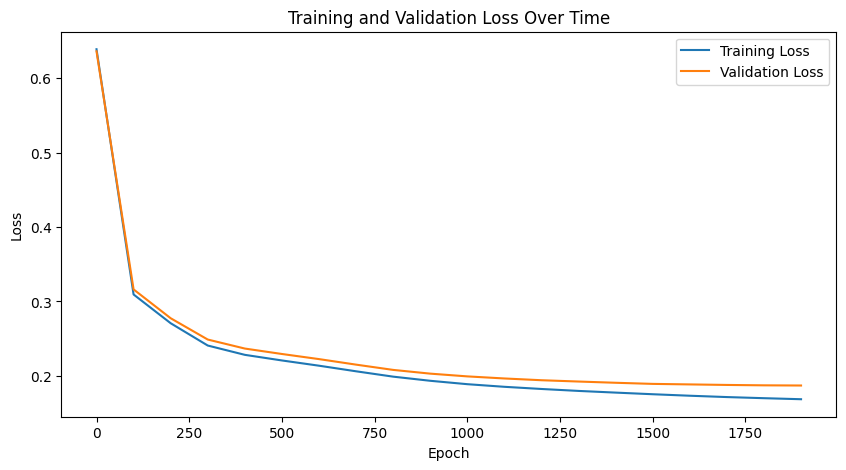

In [ ]:
# Plotting validation loss to check for overfitting
train_loss = [outputs[int(epoch/100)][3] for epoch in range(0, num_epochs, 100)]
val_loss = [outputs_val[int(epoch/100)][3] for epoch in range(0, num_epochs, 100)]
epochs = range(0, num_epochs, 100)
plt.figure(figsize=(10, 5))

plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Time')
plt.show()

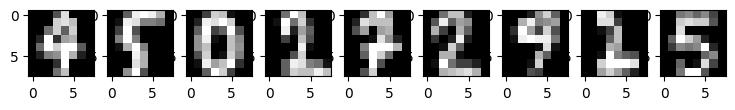

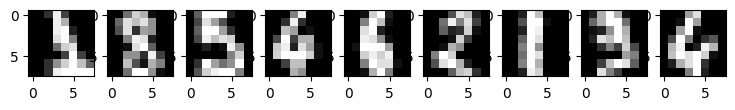

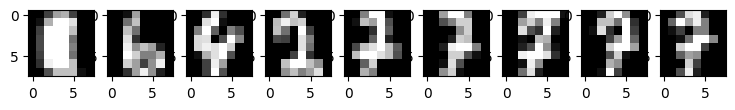

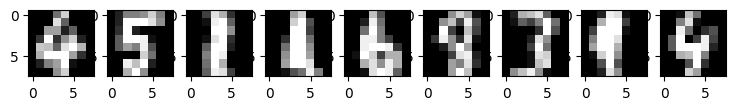

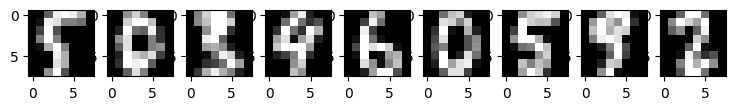

In [ ]:
num_epochs = 2000
# Plotting the visual working of the autoencoder
for k in range(0, num_epochs, 400):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[int(k/400)][1].detach().numpy()
    recon = outputs[int(k/400)][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])